# SHARKS ATTACKS

# Data import and preview of the data

Se comienza importando los datos del csv 'GSAF5' y las librerías que van a ser usadas para el análisis de los datos. A continuación se visualiza una preview del dataframe y se consulta el número de filas y columnas.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('GSAF5.csv',  encoding='mac-roman')
display(data.head())
display('Las dimensiones del dataframe son: ', data.shape)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


'Las dimensiones del dataframe son: '

(5992, 24)

# 0. Cleaning columns names

Como primer paso, se eliminan los espacios al principio y final de los nombres de las columnas para que las mismas puedan ser referenciadas sin errores.
A continuación, se aplica una fórmula para eliminar los espacios al principio y final de cada una de las celdas.

In [2]:
columns = data.columns
col_names_clean = [name.strip() for name in columns]
data.columns = col_names_clean
data = data.applymap(lambda x: x.strip() if type(x) is str else x)

#    1. Missing Values analysis

In [3]:
null_cols = data.isnull().sum()
display(null_cols[null_cols > 0])
display(null_cols[null_cols == 0])

numeric_columns = [col for col in data._get_numeric_data()]
display(numeric_columns)

Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
href formula                 1
href                         3
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64

Case Number       0
Date              0
Year              0
Type              0
pdf               0
Case Number.1     0
Case Number.2     0
original order    0
dtype: int64

['Year', 'original order']

De acuerdo a los resultados anteriores, parece correcto concluir que las columnas "Unnamed 22" and "Unnamed 23" pueden ser eliminadas.
Además, los únicos campos puramente numéricos, 'Year' y 'original order', no contienen nulos, por lo que no cabe estudiar si conviene completar esos nulos con ceros. El campo edad, que debería ser numérico, no lo es porque algunos registros contienen texto (que se limpiará o traducirá en pasos posteriores).

In [4]:
drop_cols = ['Unnamed: 22', 'Unnamed: 23']

Se observa también que el valor de los campos Case Number.1 y Case Number.2 es igual que el de Case Number. Lo verificamos con un bucle:

In [5]:
for i, row_value in data['Case Number'].iteritems():
    if row_value != data['Case Number.1'][i] and row_value != data['Case Number.2'][i]:
        print(i, 'Mismatch founded', row_value, data['Case Number.1'][i], data['Case Number.2'][i])

169 Mismatch founded 2015.07-10 2015.07.10 2015.07.10
4719 Mismatch founded 1934.01.08.R 1934.02.08.R 1934.02.08.R


Para mantener la columna 'Case Number', corregimos las discrepancias y eliminamos las columnas Case Number 1 y 2

In [6]:
data.loc[169, 'Case Number'] = data['Case Number.1'][169]
data.loc[4719, 'Case Number'] = data['Case Number.1'][4719]
drop_cols += ['Case Number.1', 'Case Number.2']

También a priori parece que el contenido de las columnas 'href formula' y 'href' es el mismo. Comprobamos:

In [7]:
mismatch_href_count = 0
for i, row_value in data['href'].iteritems():
    if row_value != data['href formula'][i]:
        #print(i, 'Mismatch founded', row_value, data['href formula'][i])
        mismatch_href_count += 1
display("Diferencias encontradas 'href' vs 'href formula' :", mismatch_href_count)

"Diferencias encontradas 'href' vs 'href formula' :"

53

Se puede ver que para 53 filas, los contenidos de las columnas no coinciden. Sin embargo, dado que este valor no llega al 1% de los registros, lo consideramos despreciable. Además, el contenido del campo no nos aporta información para nuestro análisis a alto nivel. Por tanto, eliminamos también la columna 'href'.

In [8]:
drop_cols += ['href']
data = data.drop(drop_cols, axis=1)

# 2. Incorrect data identification

La primera idea que nos surge para comprobar la corrección de los datos es verificar si las ciudades que se lista en la columna Area pertenecen realmente al país en la columna Country. Para ello recurrimos a una librería externa, Geopy, pero nos encontramos el problema de que la ejecución de la verificación es muy lenta y de que los nombres de los países devueltos están en idioma y/o alfabeto local, con lo cual no se pueden comparar con el país mostrado en el dataset. Además, para algunas ciudades el servidor no devuelve resultad.

Se incluye el código a continuación:

In [9]:
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(timeout=3)
#for i in range(len(data['Area'])):
    #location = geolocator.geocode(data.loc[i, 'Area'])
    #if location:
    #   location = location.raw['display_name'].split(',')
    #country = location['display_name'].split(',')
    #if location[1].lower().strip() == data.loc[i, 'Country'].lower().strip():
         #print(i, location[1].lower(), data.loc[i, 'Country'].lower())

Como segundo paso a la comprobación de datos incorrectos, se podría verificar que el sexo de las víctimas coincide con el valor del campo nombre cuando en este último se incluye male o female.

In [10]:
for i in range(len(data['Sex'])):
    if data.loc[i, 'Name'] == 'male' and data.loc[i, 'Sex'] != 'M' or data.loc[i, 'Name'] == 'female' and data.loc[i, 'Sex'] != 'F':
        print(i, data.loc[i, 'Name'], data.loc[i, 'Sex'], data.loc[i, 'Injury'])

397 female M Lacerations to right foot
405 female M Arm bitten by captive shark PROVOKED INCIDENT
1046 female M Cuts & punctures to right foot
2000 male nan 2 small lacerations to bottom of foot
2824 male nan Probable drowning & scavenging
3068 male nan FATAL, thigh bitten
4112 male nan Human remains found in shark
4240 male nan Harpooned shark bit his forehead PROVOKED INCIDENT
5018 male nan FATAL
5603 female M Partial human remains found in 13' shark
5779 male nan Lacerations to leg  PROVOKED INCIDENT
5825 male nan FATAL
5865 male nan Foot severed


Se puede utilizar estos resultados para rellenar aquellos valores nulos del campo 'Sex'. Por otro lado, el número de discrepancias encontradas es despreciable.

In [11]:
data.loc[2000, 'Sex'] = 'M'
data.loc[2824, 'Sex'] = 'M'
data.loc[3068, 'Sex'] = 'M'
data.loc[4112, 'Sex'] = 'M'
data.loc[4240, 'Sex'] = 'M'
data.loc[5018, 'Sex'] = 'M'
data.loc[5779, 'Sex'] = 'M'
data.loc[5825, 'Sex'] = 'M'
data.loc[5865, 'Sex'] = 'M'

Se comprobará que todos los registros para los que el campo Injury indica 'FATAL', la columna 'Fatal (Y/N)' indica Y.

In [12]:
for i in range(len(data['Injury'])):
    if data.loc[i, 'Injury'] == 'FATAL' and data.loc[i, 'Fatal (Y/N)'] != 'Y':
        print(i, data.loc[i, 'Injury'], data.loc[i, 'Fatal (Y/N)'])

2449 FATAL nan
5718 FATAL nan


A partir de las dos discrepancias anteriores, rellenamos el valor null:

In [13]:
data.loc[2449, 'Fatal (Y/N)'] = 'Y'
data.loc[5718, 'Fatal (Y/N)'] = 'Y'

# 3. Data type correction

Para empezar se comprueba que en la columna 'Date', muchos de los valores, a pesar de tener un formato similar al de una fecha en realidad no lo son, y otros incluyen caracteres de texto como 'Reported'. Para obtener las fechas exactas expresadas en formato fecha, se recurre a la columna 'Case Number'.

In [14]:
import datetime

counter = 0
for i in range(len(data['Case Number'])):
    counter += 1
    x = data.loc[i, 'Case Number']
    #print(counter, x)
    try:
        year = int(x[:4])
        month = int(x[5:7]) if int(x[5:7]) != 0 else 1
        day = int(x[8:10]) if int(x[8:10]) != 0 else 1
        #print(counter, x, '.....', year, month, day)
        date_value = datetime.date(year, month, day)
        data.loc[i, 'Date'] = date_value
    except:
        pass


In [15]:
data_counter_not_valid_date = 0
for x in data['Date']:
    if type(x) is not datetime.date:
        data_counter_not_valid_date += 1
print('Percentage of non valid dates: ', round(data_counter_not_valid_date/len(data['Date']) * 100, 3), '%')

Percentage of non valid dates:  2.069 %


Gracias al código anterior, hemos conseguido transformar a objetos de fechas gran parte de los registros, lo que nos permitirá ubicarlos de forma correcta en un eje temporal. 
Comprobamos también que sólo un pequeño porcentaje de los registros (2.07%) no ha sido posible de ubicar de forma correcta. Estos registros, mediante análisis cualitativo, puede comprobarse que típicamente se corresponden con fechas muy lejanas.

Un vez que hemos rellenado correctamente el campo 'Date', se puede verificar que el año se corresponde con el valor del campo 'Year' mediante el código siguiente:

In [16]:
data_counter_error_years = 0

for i, row_value in data['Year'].iteritems():
    try:
        if data['Date'][i].year != row_value:
            print(i, 'Year mismatch', '     Valor del campo "Date": ', data['Date'][i], '     Valor del campo "Year": ', row_value, '    Valor de Case Number: ',data['Case Number'][i])
            data_counter_error_years += 1
    except:
        pass
    
print('Percentage of mistmatches: ', round(data_counter_error_years/len(data['Year']) * 100, 3), '%')

2449 Year mismatch      Valor del campo "Date":  1989-07-27      Valor del campo "Year":  1969     Valor de Case Number:  1989.07.27
3662 Year mismatch      Valor del campo "Date":  1961-07-16      Valor del campo "Year":  1971     Valor de Case Number:  1961.07.16
4312 Year mismatch      Valor del campo "Date":  1948-09-17      Valor del campo "Year":  1848     Valor de Case Number:  1948.09.17.R
4983 Year mismatch      Valor del campo "Date":  1923-01-01      Valor del campo "Year":  1922     Valor de Case Number:  1923.00.00.a
5043 Year mismatch      Valor del campo "Date":  1900-01-01      Valor del campo "Year":  1919     Valor de Case Number:  1900.00.00.R
Percentage of mistmatches:  0.083 %


Se comprueba que para algunos registros, los valores de ambos campos no coinciden, por lo que procedemos a corregir el campo 'Year':

In [17]:
data.loc[2449, 'Year'] = 1989
data.loc[3662, 'Year'] = 1961
data.loc[4312, 'Year'] = 1948
data.loc[4983, 'Year'] = 1923
data.loc[5043, 'Year'] = 1900

A continuación se hará que todos los campos no númericos (todos menos 'Date', 'Year', 'original order' y 'Age'] sean strings.

In [18]:
text_columns = ['Country', 'Area', 'Location', 'Activity', 'Name', 'Sex', 'Injury', 'Fatal (Y/N)', 'Time', 'Species', 'Investigator or Source', 'pdf', 'href formula']
data[text_columns] = data[text_columns].astype('str')
data['Country'] = data['Country'].astype(str)
data.dtypes

Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
original order             int64
dtype: object

# 3. Values normalization

Para facilitar las tareas de análisis finales, se tratará de normalizar los valores de cada columna en la medida de lo posible eliminando espacios y caracteres especiales.

COLUMNA 'Activity':

In [19]:
data['Type'].unique()

array(['Unprovoked', 'Boat', 'Provoked', 'Invalid', 'Sea Disaster',
       'Boating'], dtype=object)

Los resultados Boat y Boating paracen ser la misma categoría, por lo que normalizaremos los valores renombrado los 'boating' como 'boat'.

In [20]:
data['Type'] = data['Type'].str.replace('Boating', 'Boat')
data['Type'].unique()

array(['Unprovoked', 'Boat', 'Provoked', 'Invalid', 'Sea Disaster'],
      dtype=object)

COLUMNA 'Country':

In [21]:
display(np.sort(data['Country'].unique()))
display(data.groupby(['Country']).size())
#display(data.groupby('Country').count())

array(['ADMIRALTY ISLANDS', 'ALGERIA', 'AMERICAN SAMOA',
       'ANDAMAN / NICOBAR ISLANDAS', 'ANGOLA', 'ANTIGUA', 'ARGENTINA',
       'ARUBA', 'ASIA?', 'ATLANTIC OCEAN', 'AUSTRALIA', 'AZORES',
       'BAHAMAS', 'BAHREIN', 'BANGLADESH', 'BARBADOS', 'BAY OF BENGAL',
       'BELIZE', 'BERMUDA', 'BRAZIL', 'BRITISH ISLES',
       'BRITISH NEW GUINEA', 'BRITISH VIRGIN ISLANDS',
       'BRITISH WEST INDIES', 'BURMA', 'Between PORTUGAL & INDIA',
       'CANADA', 'CAPE VERDE', 'CARIBBEAN SEA', 'CAYMAN ISLANDS',
       'CENTRAL PACIFIC', 'CEYLON (SRI LANKA)', 'CHILE', 'CHINA',
       'COLUMBIA', 'COOK ISLANDS', 'COSTA RICA', 'CRETE', 'CROATIA',
       'CUBA', 'CURACAO', 'CYPRUS', 'Coast of AFRICA', 'DIEGO GARCIA',
       'DJIBOUTI', 'DOMINICAN REPUBLIC', 'ECUADOR', 'EGYPT',
       'EGYPT / ISRAEL', 'EL SALVADOR', 'ENGLAND',
       'EQUATORIAL GUINEA / CAMEROON', 'FALKLAND ISLANDS',
       'FEDERATED STATES OF MICRONESIA', 'FIJI', 'FRANCE',
       'FRENCH POLYNESIA', 'Fiji', 'GABON', 'GEORGIA', 

Country
ADMIRALTY ISLANDS                1
ALGERIA                          1
AMERICAN SAMOA                   3
ANDAMAN / NICOBAR ISLANDAS       1
ANGOLA                           1
ANTIGUA                          1
ARGENTINA                        1
ARUBA                            1
ASIA?                            1
ATLANTIC OCEAN                  16
AUSTRALIA                     1279
AZORES                           5
BAHAMAS                         98
BAHREIN                          1
BANGLADESH                       1
BARBADOS                         5
BAY OF BENGAL                    1
BELIZE                           3
BERMUDA                         16
BRAZIL                         102
BRITISH ISLES                    1
BRITISH NEW GUINEA               1
BRITISH VIRGIN ISLANDS           1
BRITISH WEST INDIES              1
BURMA                            4
Between PORTUGAL & INDIA         1
CANADA                          10
CAPE VERDE                       3
CARIBBEAN SE

Se observa que no se repiten los valores de los países, aunque hay uno de ellos que no es un país "Diego García" y la mayoría de los países aparecen en un único registro.

COLUMNA 'Area':
La información de esta columna, pese a ser interesante, es demasiado específica y contiene muchos valores distintos, por lo que no se normalizará para el análisis:

In [22]:
display(data.groupby(['Area']).size())

Area
"Head of the Gulf"                                                  1
(Southwestern Pacific)                                              1
04.05N-13.23W                                                       1
1,000 miles east of Hawaii                                          1
1000 miles west of Hawaii                                           2
10∫S, 142∫E                                                         1
12 miles off the north coast                                        1
150 miles offshore                                                  1
165  miles from Bermuda                                             1
180 miles southeast of Okinawa                                      1
18S / 50E                                                           1
19S, 178?E                                                          1
2 to 3 miles off Taboguilla Island, Pacific Ocean                   1
200 nm southeast of Manila                                          1
22∫N, 88∫E     

COLUMNA 'Name':
No contiene información relevante para el análisis más allá del sexo de algunas víctimas usada en apartados anteriores.

COLUMNA 'Injury':
No contiene información relevante nuestro análisis al tener muchos resultados unívocos. Sólo ha sido usada anteriormente para corregir o completar los valores de 'Fatal Y/N' La información relacionada con esta columna que usaremos será la de la columna 'Fatal Y/N'. más allá del sexo de algunas víctimas usada en apartados anteriores.

COLUMNA 'Fatal Y/N':

In [23]:
display(data['Fatal (Y/N)'].unique())
display(data.groupby(['Fatal (Y/N)']).size())

array(['N', 'Y', 'nan', 'UNKNOWN', 'F', '#VALUE!', 'n'], dtype=object)

Fatal (Y/N)
#VALUE!       1
F             1
N          4324
UNKNOWN      94
Y          1554
n             1
nan          17
dtype: int64

In [24]:
"""
Corregimos transformando:
n -> N
F -> Y
nan -> UNKNOWN
VALUE! -> UNKNOWN
"""
data['Fatal (Y/N)'] = data['Fatal (Y/N)'].str.replace('nan', 'UNKNOWN').replace('n', 'N').replace('F', 'Y').replace('#VALUE!', 'UNKNOWN')

COLUMNA 'Age':

En primer lugar, sustituimos los valores 'Teen' por el valor 15 (edad estimada).
Para todos los valores, la función aplicada extrae únicamente los valores numéricos. En caso de que se hayan devuelto cero o más de 2 valores, rellenamos con ceros.
Finalmente, rellenamos todos los ceros con el valor medio de los valores correctos.

In [25]:
try:
    data['Age'] = data['Age'].str.replace('Teen', 15)
except:
    pass

def translate_age(row_value):
    try:
        numbers = re.findall('[0-9]', row_value)
        if len(numbers) == 1 or len(numbers) == 2:
            return int(''.join(numbers))
        else:
            return 0
    except:
        return 0
    
data['Age'] = data['Age'].apply(translate_age)

mean_age = data['Age'][(data['Age'] > 0)].mean()
data.loc[(data['Age']==0), 'Age'] = round(mean_age, 2)

data['Age'] = data['Age'].astype('int64')

data['Age']

0       16
1       36
2       43
3       27
4       27
5       27
6       60
7       51
8       50
9       12
10      27
11       9
12      22
13      25
14      37
15      20
16      49
17      15
18      21
19      22
20      40
21      72
22      27
23      43
24      18
25      29
26      36
27      27
28      31
29      27
        ..
5962    27
5963    27
5964    27
5965    27
5966    16
5967    27
5968    27
5969    27
5970    27
5971    27
5972    27
5973    27
5974    27
5975    27
5976    27
5977    27
5978    27
5979    27
5980    27
5981    27
5982    27
5983    27
5984    27
5985    27
5986    27
5987    27
5988    27
5989    27
5990    27
5991    15
Name: Age, Length: 5992, dtype: int64

COLUMNA 'Species':
Para esta columna, podría ser interesante normalizar los datos sustituyendo los valores de la columna por el nombre del tiburón, por ejemplo 'White', 'Bull' y 'Grey'. Pero dado que muchos de los registros no contienen ninguna referencia a la especie del tiburón atacante, o incluso están en blanco, la información aportada por el campo estaría muy sesgada.
Debido al alto número de distintos tipos de tiburones reportados.

In [26]:
display(data['Species'].unique())
display(data.groupby(['Species']).size())

array(['nan', '2 m shark', "3' to 4' shark", ..., "12' tiger shark",
       'Blue pointers',
       'Said to involve a grey nurse shark that leapt out of the water and  seized the boy but species identification is questionable'],
      dtype=object)

Species
                                                                                                                                      6
"A 2' (0.6 m) brown shark"                                                                                                            1
"A long thin brown-colored shark"                                                                                                     1
"A pack of 6 sharks"                                                                                                                  1
"A pack of sharks"                                                                                                                    1
"A small shark"                                                                                                                       2
"Attacked by a number of sharks"                                                                                                      1
"Blue nose shark"                       

No existen columnas susceptibles de ser analizadas para determinar una varianza baja, por lo que no se llevará a cabo esa parte del roceso de limipieza.
Sí se eliminarán registros duplicados.

In [27]:
data = data.drop_duplicates()

Finalmente se exporta el archivo:

In [28]:
data.to_csv('shark_attacks_ds_clean.csv', index=False)

# Conclusions

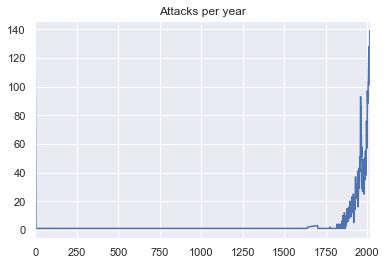

In [29]:
sns.set()
years_count = data['Year'].value_counts().sort_index()
years_count.plot(title = 'Attacks per year')

Observamos que el gráfico no muestra con precisión la evolución de ataques de tiburón registrados por año, ya que el eje es muy extenso y antes de 1850 aproximadamente no se manejaban datos.
Debido a esto, filtramos los datos de la columna año para aquellos posteriores a 1850 y representamos de nuevo:

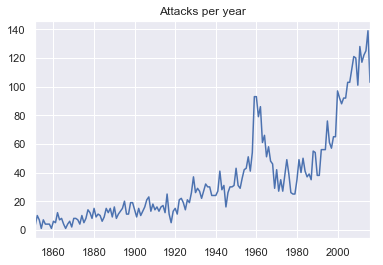

In [30]:
significant_years = data['Year'][(data['Year'] > 1850)]
significant_years_count = significant_years.value_counts().sort_index()
significant_years_count.plot(title="Attacks per year")

Efectivamente, ahora sí podemos comprobar cómo la evolución del número de ataques registrados ha sido creciente, teniendo un pico en el año 1960 y aumentando la pendiente de crecimiento de forma considerable a partir de 1990 aproximadamente.

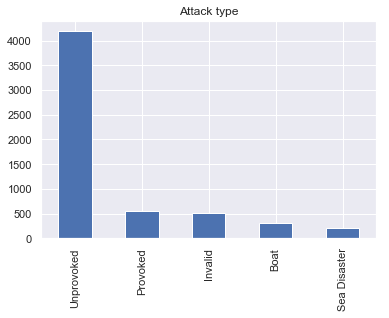

In [31]:
attack_type = data[(data['Year'] > 1850)]['Type'].value_counts()
attack_type.plot(kind='bar', title = 'Attack type')

Se comprueba que la mayor parte de los ataques son no provocados, es decir, que el tiburón ataca en primera instancia cuando se está realizando algún tipo de actividad naútica o similar (ver siguiente gráfico).

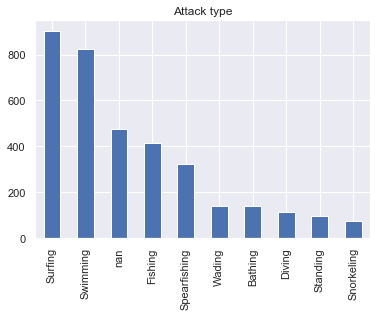

In [32]:
activity = data[(data['Year'] > 1850)]['Activity'].value_counts().head(10)
activity.plot(kind='bar', title = 'Attack type')

De acuerdo con la conclusión anterior, se observa que gran parte de los ataques se producen durante actividades de ocio no realizadas con la pesca de tiburones, como el surf y la natación. Por tanto, el mayor riesgo está en aquellos deportes náuticos en los que la víctima potencial se encuentra en contacto directo con el agua.

Analizamos a continuación la mortalidad confirmada, expresado en porcentajes sobre el total:

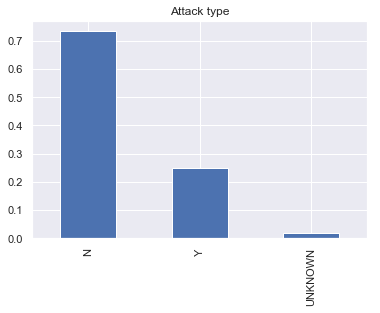

In [34]:
fatality = data[(data['Year'] > 1850)]['Fatal (Y/N)'].value_counts(normalize = True)
fatality.plot(kind='bar', title = 'Attack type')

En la mayoría de los casos reportados, solo un 25% aprox. de las víctimas fallece, frente al 73% aprox que sobrevive. De un 2% de los casos restantes se desconoce el final. Faltaría investigar en más profundidad el nivel de daño causado a los supervivientes si se dispusiera de un campo estandarizado a ese respecto.